### Introduction

In this notebook, we aim to evaluate the performance and consistency of our pre-trained coin classification model on the third largest class in our dataset. The model was originally trained on the two largest classes. By testing the third class, we seek to understand whether it shares similarities with the classes the model was trained on and if the model can accurately classify images from this third class.

**Key Objectives**:
1. **Load the Pre-trained Model**: We will load the model that was trained on the two largest classes to ensure consistency in our evaluation.
2. **Prepare the Third Class Dataset**: Images from the third largest class will be loaded and preprocessed to match the format used in the original training.
3. **Evaluate Model Performance**: The pre-trained model will be tested on the third class dataset to assess its performance.
4. **Analyze Consistency**: We will analyze the consistency of the model's classification results on the third class to determine if the model can generalize its learned features to this new class.

By the end of this notebook, we will gain insights into the model's ability to handle unseen classes and its potential for generalization beyond the initial training set. This analysis will help us understand the model's strengths and limitations, guiding future improvements and training strategies.

---


In [47]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils import normalize
from tensorflow.keras.layers import Flatten, Dense, Dropout


import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import random

We are testing the model on `al-Mahdiyah` class

In [48]:
class_label = 'al-Mahdiyah'
csv_file_path = 'image_labels.csv'
data_path = "Combined_images"

file_names = []

# Iterate over each file in the specified directory
for filename in os.listdir(data_path):
    if filename.endswith(('.jpg', '.png', '.tif', '.JPG')):
        file_names.append(filename)

# Function to extract the number from the image filename
def extract_number_from_filename(filename):
    return filename.split('_')[1].split('.')[0]

image_names = []

for name in file_names:
    image_names.append(extract_number_from_filename(name))

In [49]:
# Function to read the CSV and create a dictionary of image names to labels
def read_csv_to_dict(csv_file):
    df = pd.read_csv(csv_file)

    # Extract image names and labels
    image_names = df.iloc[:, 0].values
    labels = df.iloc[:, -1].values

    # Create a list of image-label pairs
    image_label_array = np.array([[name, label] for name, label in zip(image_names, labels)])
    
    # Convert the NumPy array to a dictionary
    image_label_dict = {row[0]: row[1] for row in image_label_array}
    return image_label_dict

In [50]:
image_label_dict = read_csv_to_dict(csv_file_path)

# Function to load and preprocess images
def load_and_preprocess_image(file_path):
    img = load_img(file_path, target_size=(224, 224))
    img_array = img_to_array(img)
    return img_array

In [51]:
# Search for image files and load images and labels
images = []
image_labels = []
for key, label in image_label_dict.items():
    found = False
    for root, _, files in os.walk(data_path):
        for file in files:
            if key in file and label == class_label:
                file_path = os.path.join(root, file)
                img_array = load_and_preprocess_image(file_path)
                images.append(img_array)
                image_labels.append(label)
                found = True
                break
        if found:
            break

# Convert to numpy arrays
images = np.array(images)
image_labels = np.array(image_labels)

# Encode labels as integers
label_to_index = {label: idx for idx, label in enumerate(np.unique(image_labels))}
index_to_label = {idx: label for label, idx in label_to_index.items()}
image_labels = np.array([label_to_index[label] for label in image_labels])

#### Load Pre-trained Model

In this section, we will load the pre-trained model that was trained on the two largest classes.   
This will allow us to evaluate its performance on the third largest class.

In [52]:
# Function to create the model with the same architecture as the pre-trained model
def create_model(num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Add custom top layers for transfer learning
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Combine base model and new top layers
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the base model (not trainable)
    for layer in base_model.layers:
        layer.trainable = False

    return model

# Load the model with the same architecture as the previous one
num_classes = 2  # Change to the number of classes in your pre-trained model
model = create_model(num_classes)
model.load_weights('fine_tuned_vgg16.h5')


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Evaluate Model Performance on the Third Class
In this section, we will evaluate the model's performance on the third largest class.


In [53]:
preprocessed_images = preprocess_input(images)

predictions = model.predict(preprocessed_images)
predicted_class = np.argmax(predictions, axis=1)

print(predicted_class)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 825ms/step
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


In [54]:
classes = ['Misr', 'al-Mansuriyah']

for i, img_array in enumerate(preprocessed_images):
    true_class = image_labels[i]
    print(f"True class: {index_to_label[true_class]}" ,end=', ')
    print(f"Predicted class: {classes[predicted_class[i]]}")
    print("------")

True class: al-Mahdiyah, Predicted class: al-Mansuriyah
------
True class: al-Mahdiyah, Predicted class: al-Mansuriyah
------
True class: al-Mahdiyah, Predicted class: al-Mansuriyah
------
True class: al-Mahdiyah, Predicted class: al-Mansuriyah
------
True class: al-Mahdiyah, Predicted class: al-Mansuriyah
------
True class: al-Mahdiyah, Predicted class: al-Mansuriyah
------
True class: al-Mahdiyah, Predicted class: al-Mansuriyah
------
True class: al-Mahdiyah, Predicted class: Misr
------
True class: al-Mahdiyah, Predicted class: al-Mansuriyah
------
True class: al-Mahdiyah, Predicted class: al-Mansuriyah
------
True class: al-Mahdiyah, Predicted class: al-Mansuriyah
------
True class: al-Mahdiyah, Predicted class: al-Mansuriyah
------
True class: al-Mahdiyah, Predicted class: al-Mansuriyah
------
True class: al-Mahdiyah, Predicted class: al-Mansuriyah
------
True class: al-Mahdiyah, Predicted class: al-Mansuriyah
------
True class: al-Mahdiyah, Predicted class: Misr
------
True class


#### Conclusion
We can see that except for 3 images, all the images are classified as 'al-Mansuriyah'.  
This can help us infer that the 'al-Mahdiyah' class might be similar to class 1 ('al-Mansuriyah').    
This similarity suggests that the features learned by the model for class 1 are also applicable to the 'al-Mahdiyah' class, leading to consistent classification results.  
Further investigation and analysis may be required to confirm this hypothesis and understand the underlying reasons for this similarity.

---

Now, we will use the Grad-CAM algorithm to visualize the regions of the images that the model is focusing on when making predictions.

In [55]:
# Convert array to image
def array_to_img(array):
    array = array * 255
    array = np.uint8(array)
    img = cv2.cvtColor(array, cv2.COLOR_RGB2BGR)
    return img

# Load and preprocess the image
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array


# Superimpose the Grad-CAM heatmap on the original image
def superimpose_heatmap_on_image(img, heatmap, colormap=cv2.COLORMAP_JET):
    plt.figure(figsize=(3, 3))
    img = array_to_img(img[0])  # Convert array to image (remove the batch dimension)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Generate Grad-CAM heatmap with different techniques
def generate_gradcam_heatmap(model, img_array, penultimate_layer='block5_conv3', clone=False, predicted_class=None):
    # Define the score for the target class
    score = CategoricalScore([predicted_class])

    # Generate heatmap
    gradcam = Gradcam(model, model_modifier=ReplaceToLinear(), clone=clone)
    heatmap = gradcam(score, img_array, penultimate_layer=penultimate_layer)
    
    heatmap = normalize(heatmap)
    heatmap = heatmap[0]  # Extract the heatmap for further processing

    return heatmap


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step
[3.0661788e-26 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


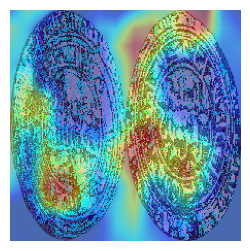

[6.4224615e-32 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


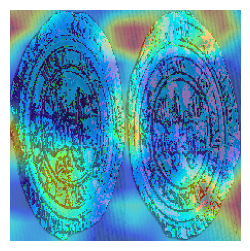

[2.3180252e-26 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


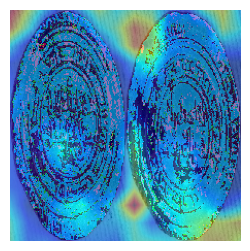

[1.3565006e-16 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


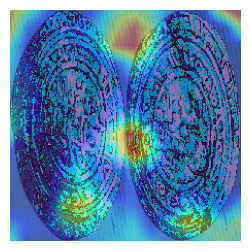

[9.092545e-15 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


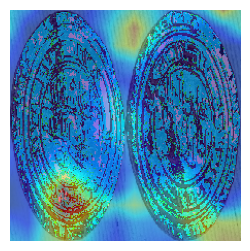

[3.013032e-16 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


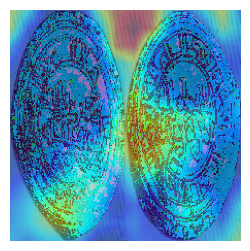

[1.3642588e-16 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


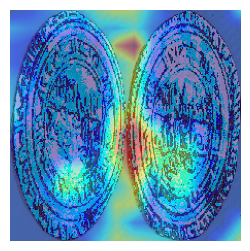

[1.000000e+00 1.130195e-24]
True class: al-Mahdiyah
Predicted class: Misr


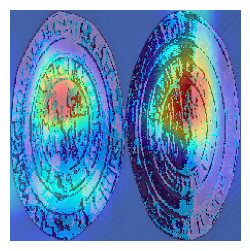

[0. 1.]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


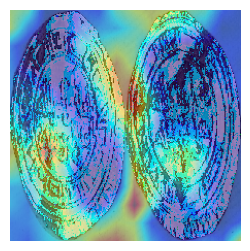

[9.740072e-08 9.999999e-01]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


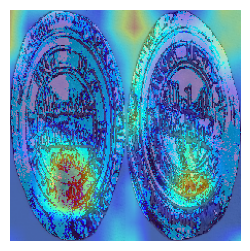

[3.2530486e-22 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


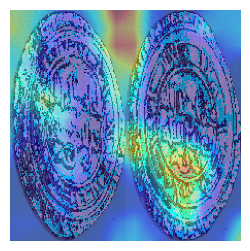

[5.8400856e-27 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


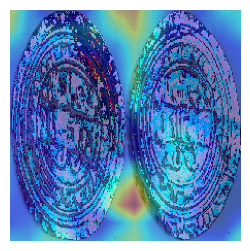

[4.976116e-05 9.999503e-01]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


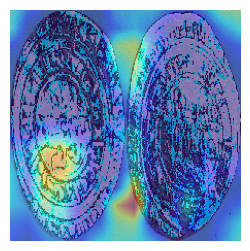

[2.3387684e-23 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


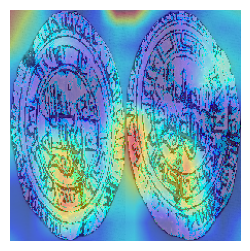

[2.7291863e-34 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


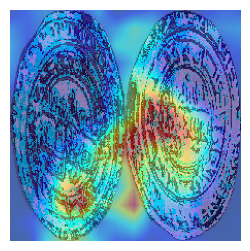

[1.0000000e+00 5.7703465e-21]
True class: al-Mahdiyah
Predicted class: Misr


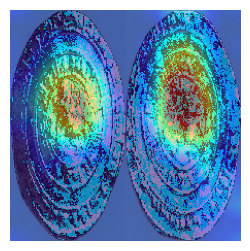

[2.4324308e-27 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


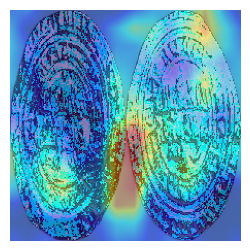

[1.4913909e-04 9.9985087e-01]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


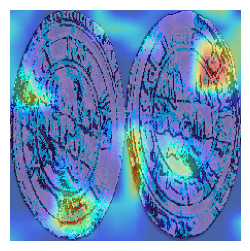

[2.3423087e-19 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


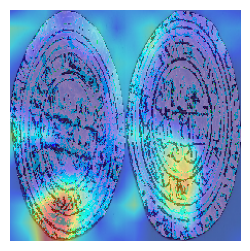

[8.597879e-31 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


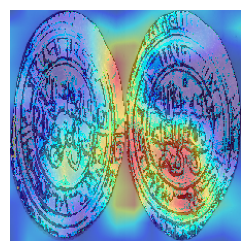

[1.01887444e-25 1.00000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


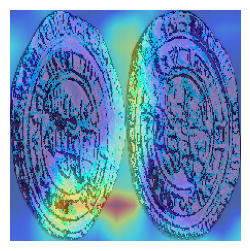

[3.158252e-19 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


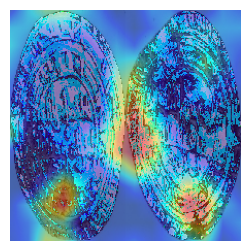

[4.0133383e-27 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


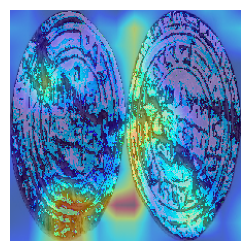

[5.667146e-27 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


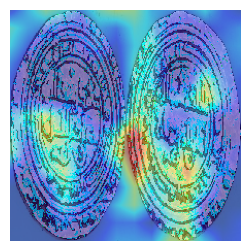

[2.636391e-13 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


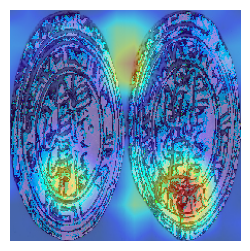

[1.7128398e-19 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


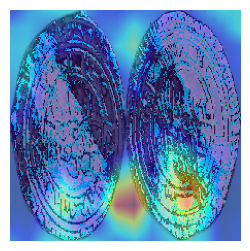

[8.0797e-24 1.0000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


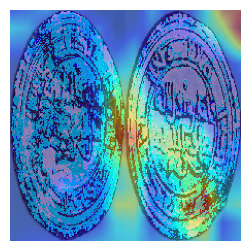

[1.00438775e-25 1.00000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


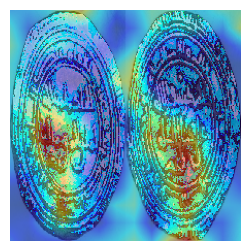

[4.772767e-17 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


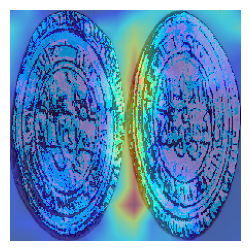

[6.947124e-23 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


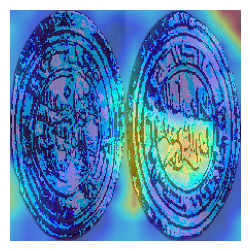

[1.013214e-13 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


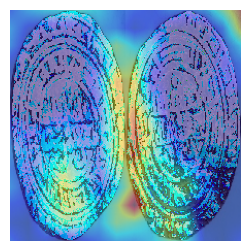

[7.875348e-20 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


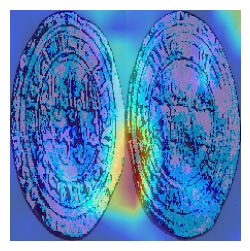

[7.250906e-35 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


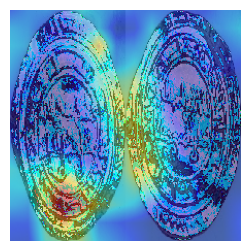

[1.09321024e-16 1.00000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


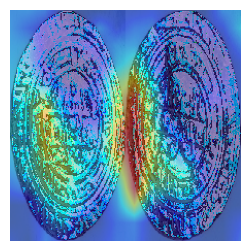

[0.9210373  0.07896264]
True class: al-Mahdiyah
Predicted class: Misr


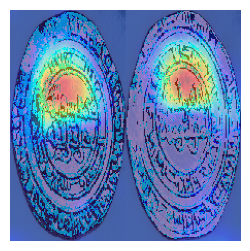

[5.34658e-29 1.00000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


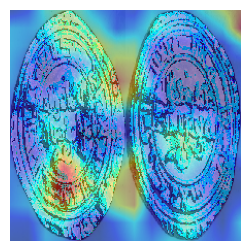

[6.8589394e-37 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


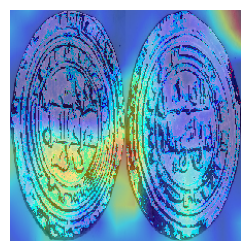

In [56]:
# Sample predictions and Grad-CAM visualization
predictions = model.predict(preprocessed_images)
for i, img in enumerate(preprocessed_images):
    print(predictions[i])
    predicted_class = np.argmax(predictions[i])
    print(f"True class: {class_label}")
    print(f"Predicted class: {classes[predicted_class]}")
    heatmap = generate_gradcam_heatmap(model, np.expand_dims(img, axis=0), penultimate_layer='block5_conv3', clone=False, predicted_class=predicted_class)
    superimpose_heatmap_on_image(np.expand_dims(img, axis=0), heatmap)